## Gradient Descent
*Gradient Descent* is an iterative method to find a local minimum of a function $f: \mathbb{R}^{d} \to \mathbb{R}$. The algorithm starts with an arbitrary estimate $\mathbb{x}^{(0)} \in \mathbb{R}^{d}$ and produces a sequence of estimates $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots$ according to the following update rule:
\begin{equation*}
    \mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} - \alpha_t \nabla f(\mathbf{x}^{(t)}),
\end{equation*}
where $\alpha_t \in \mathbb{R}_{+}$ is called the *step size* (note that it is allowed to change in every iteration). Since the gradient of $f$ points in the direction of steepest ascent, subtracting the gradient updates the estimate towards the direction of steepest descent. The algorithm terminates when $\lVert \nabla f(\mathbf{x}^{(t)}) \rVert < \varepsilon$ for some small $\varepsilon > 0$, i.e., when it (approximately) reaches a critical point of $f$. Note that convergence is not guaranteed in the general case, so it makes sense to enforce a hard limit on the number of iterations.

In this exercise we are going to perform gradient descent on Himmelblau's function, a polynomial of degree four in two variables:
\begin{align}
    f: && \mathbb{R}^{2} &\to \mathbb{R}\\
    &&\left(\begin{matrix}x \\ y\end{matrix}\right) &\mapsto (x^2 + y - 11)^2 + (x + y^2 - 7)^2
\end{align}
Specifically, your tasks are as follows:
1. Implement the gradient descent method on Himmelblau's function. Your routine should return the whole list of iterates $\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \ldots$, so that you can also visualize the trajectory. The code skeleton already plots Himmelblau's function, so you can use the [`plot`](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#line-plots) method of Matplotlib's `Axes3D` object to draw the trajectory into the same figure. Choose $\mathbf{x}^{(0)}$ uniformly random from the square spanned by the two points $(\begin{matrix}-6 & -6\end{matrix})^T$ and $(\begin{matrix}6 & 6\end{matrix})^T$ and run the algorithm for several draws of $\mathbf{x}^{(0)}$.
2. Play around with the step size and visualize the result to see what happens.
3. Another popular method for finding local optima is called *Newton's Method*. It works exactly in the same way as gradient descent, except that the step size in the update formula is replaced by the inverse of the hessian matrix of $f$:
\begin{equation*}
    \mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} - H_f(\mathbf{x}^{(t)})^{-1} \nabla f(\mathbf{x}^{(t)})
\end{equation*}
Implement Newton's method in the same way as you did for gradient descent including the visualization and run the cell for a few times to see what happens.
4. Compare the two methods. What differences did you notice regarding, for example, the number of iterations till convergence, the trajectories, etc.?
5. You have probably noticed by now that our simple version of Newton's method often ends up in saddle points or even the local maximum. One way of mitigating this is to perform the update step only if the hessian matrix $H_f(\mathbf{x}^{(t)})$ is positive definite and to fall back to a simple gradient descent update otherwise. Implement and visualize this 'improved' version of Newton's method.

In [136]:
import numpy as np


def himmelblau_wrapper(func):
    """
    This decorator allows passing one array containing [x,y]
    to the functions instead of both parameters separately
    """
    def wrapper(x):
        return func(*x)
    
    return wrapper

@himmelblau_wrapper
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

@himmelblau_wrapper
def himmelblau_gradient(x, y):
    x_bar = 4*x*(x**2 + y - 11) + 2*(x + y**2 - 7)
    y_bar = 2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)
    return np.array([x_bar, y_bar])

@himmelblau_wrapper
def himmelblau_hessian(x, y):
    xx_bar = 4*(x**2 + y - 11) + 8*x**2 + 2
    yy_bar = 2 + 4*(x + y**2 - 7) + 8*y**2
    xy_bar = 4*x + 4*y
    return np.array([[xx_bar, xy_bar], [xy_bar, yy_bar]])


def gradient_descent(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=1000, eps=1e-7):
    x = x_0.copy()
    trajectory = []
    
    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        x -= step_size * grad
        
        if np.sum(grad**2) < eps*eps:
            break
    
    return np.stack(trajectory, axis=-1)

def newtons_method(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=100, eps=1e-7):
    x = x_0.copy()
    trajectory = []

    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        hessian = f_hessian(x)
        
        x -= np.matmul(np.linalg.inv(hessian), grad)
        
        if np.sum(grad**2) < eps*eps:
            break

    return np.stack(trajectory, axis=-1)

def improved_newton(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=100, eps=1e-7):
    x = x_0.copy()
    trajectory = []

    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        hessian = f_hessian(x)
        direction = np.matmul(np.linalg.inv(hessian), grad)        
        eigen = np.linalg.eigvalsh(hessian)
        
        if np.all(eigen > 0):
            x -= direction
        else:
            x -= step_size * grad
        
        if np.sum(grad**2) < eps*eps:
            break

    return np.stack(trajectory, axis=-1)

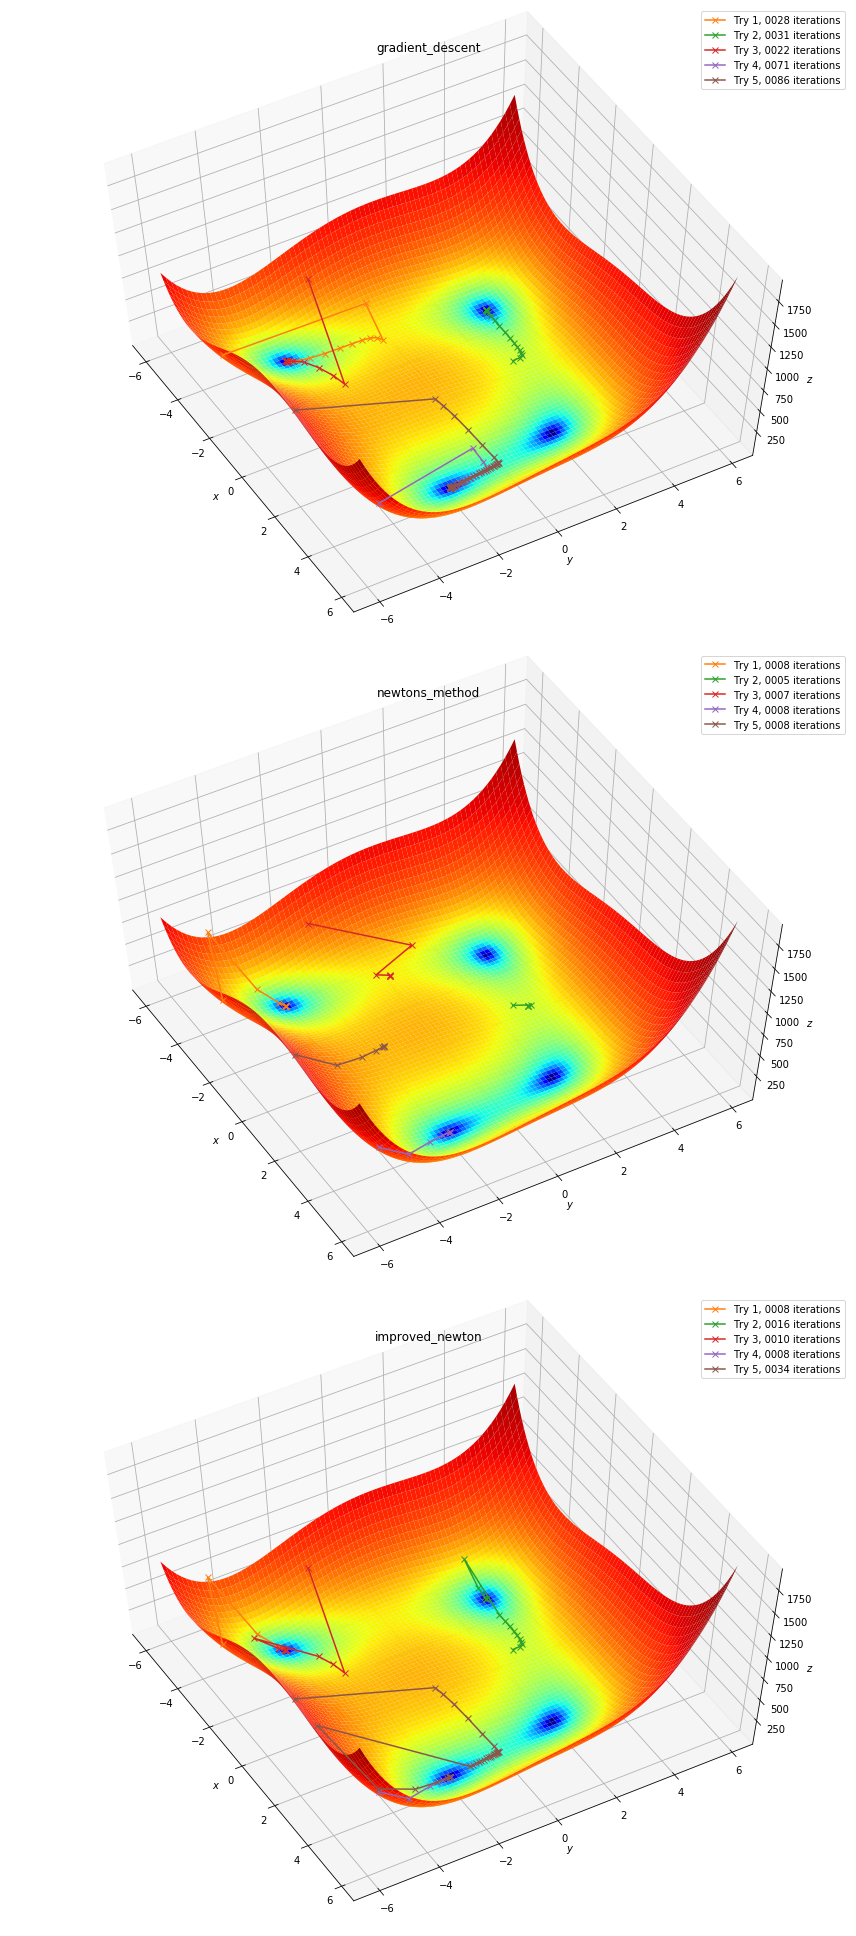

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

def make_himmelblau_plot(ax, x, y):
    ax.view_init(elev=60, azim=-30)
    ax.plot_surface(x, y, himmelblau([x,y]), cstride=1, rstride=1, norm=colors.LogNorm(), cmap=plt.cm.jet)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

x = np.arange(-6, 6, 0.15)
y = np.arange(-6, 6, 0.15)
x, y = np.meshgrid(x, y)
retries = 5
x_0 = np.random.uniform(-6, 6, size=(retries, 2))
methods = [gradient_descent, newtons_method, improved_newton]

fig, axes = plt.subplots(len(methods), 1, figsize=(12, 27), subplot_kw=dict(projection='3d'))
for ax, method in zip(axes, methods):
    make_himmelblau_plot(ax, x, y)
    ax.set_autoscale_on(False)
    ax.set_title(method.__name__)
    
    for t in range(retries):
        trace = method(himmelblau, himmelblau_gradient, himmelblau_hessian, x_0[t])
        ax.plot(trace[0], trace[1], himmelblau(trace), marker='x', 
                label='Try %d, %04d iterations' % (t+1, trace.shape[1]), zorder=3)
    ax.legend()


fig.tight_layout()
plt.show()
plt.close(fig)